In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

scaler =MinMaxScaler()

from sklearn.metrics import r2_score

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor






In [25]:
bikeSharingDf=pd.read_csv('day.csv')

print(bikeSharingDf.info())
bikeSharingDf.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Observation
- There are 730 rows with no null values so data is in good condition
- used df.info() method to evaluate null values in dataframe
- There are many categorical columns so we need to create a dummy variables for some
    * yr,mnth,weekday,season,weathersit,workingday,holiday
    * Out of these yr,workingday,holiday are already in binary so no need to create dummy varibles for them
    * Only mnth,weekday,season,weathersit need to be converted

### Plotting pair plot to identify relationship of columns

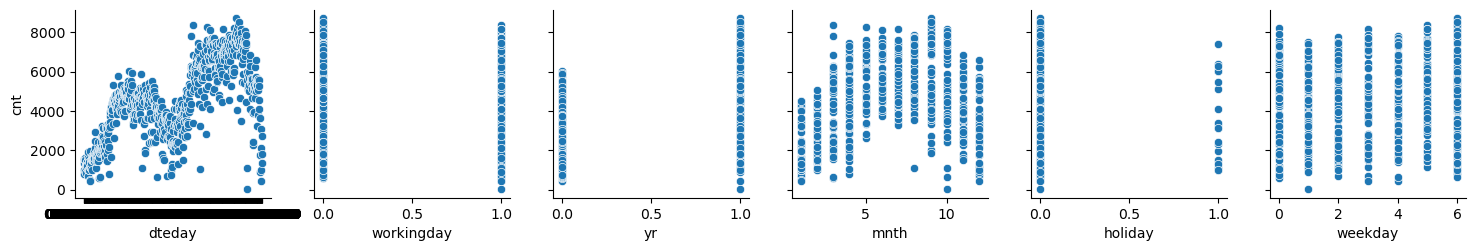

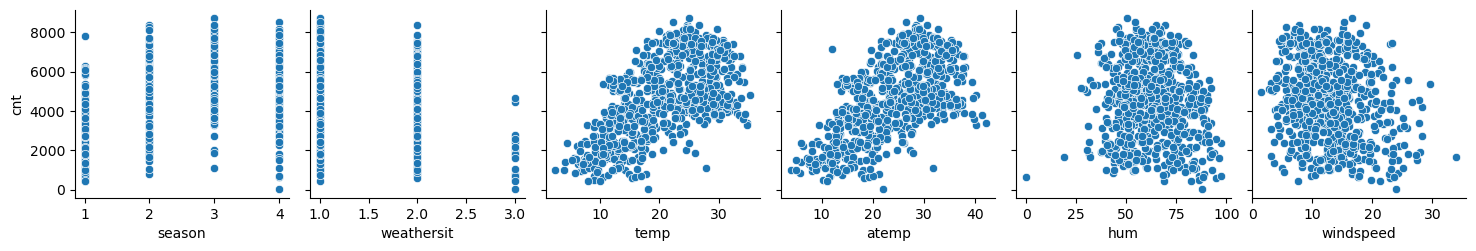

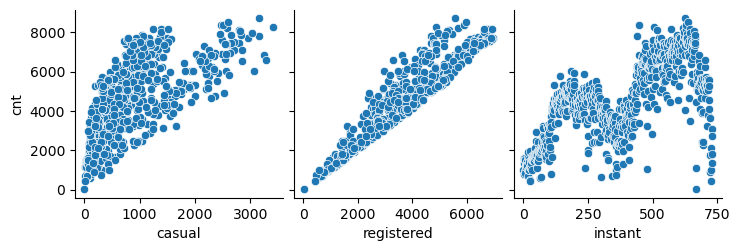

In [26]:
sns.pairplot(data=bikeSharingDf, y_vars='cnt',x_vars=['dteday', 'workingday', 'yr', 'mnth','holiday','weekday'])
sns.pairplot(data=bikeSharingDf, y_vars='cnt',x_vars=['season','weathersit','temp', 'atemp','hum','windspeed'])
sns.pairplot(data=bikeSharingDf, y_vars='cnt',x_vars=['casual', 'registered','instant'])
plt.show()


### Observation
- We should not consider columns dteday, casual and registered. dteday and instant are of no significance
- <b>cnt is direct sum of casual and registered. This will result in high multicolinear issues as CNT is completly explained by casual and registered</b>.
- 'workingday', 'yr', 'mnth','holiday','weekday','season','weathersit','temp', 'atemp','hum','windspeed' can be good candidates for linear regression model, but need dummy variables for <b>mnth,weekday,season,weathersit</b>

In [27]:
bikeSrRelavantDf=bikeSharingDf[['season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 
              'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt']]

def monthText(monthNum):
    return calendar.month_name[monthNum]

def dayText(dayNum):
    return calendar.day_name[dayNum]

def seasonText(seasonNum):
    if seasonNum==1:
        return 'spring'
    if seasonNum==2:
        return 'summer'
    if seasonNum==3:
        return 'fall'
    if seasonNum==4:
        return 'winter'
    
def weatherText(weather):
    if weather==1:
        return 'clear'
    if weather==2:
        return 'mist'
    if weather==3:
        return 'light snow'
    if weather==4:
        return 'heavy rain'

bikeSrRelavantDf['mnth']=bikeSrRelavantDf['mnth'].apply(monthText)
bikeSrRelavantDf['weekday']=bikeSrRelavantDf['weekday'].apply(dayText)
bikeSrRelavantDf['season']=bikeSrRelavantDf['season'].apply(seasonText)
bikeSrRelavantDf['weathersit']=bikeSrRelavantDf['weathersit'].apply(weatherText)

dummyColLst=['mnth','weekday','season','weathersit']

seasons=pd.get_dummies(bikeSrRelavantDf['season'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,seasons],axis=1)

weathersit=pd.get_dummies(bikeSrRelavantDf['weathersit'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,weathersit],axis=1)

weekday=pd.get_dummies(bikeSrRelavantDf['weekday'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,weekday],axis=1)


mnth=pd.get_dummies(bikeSrRelavantDf['mnth'],drop_first=True)
bikeSrRelavantDf=pd.concat([bikeSrRelavantDf,mnth],axis=1)


bikeSrRelavantDf=bikeSrRelavantDf.drop(columns=dummyColLst)
bikeSrRelavantDf.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,December,February,January,July,June,March,May,November,October,September
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


## Dividing data into Test and Train

In [28]:
train_bikeSrRelavantDf, test_bikeSrRelavantDf=train_test_split(bikeSrRelavantDf,train_size=.7, 
                                                               test_size = 0.3,random_state=100)
print('train data ',train_bikeSrRelavantDf.shape)
print('test data ',test_bikeSrRelavantDf.shape)



train data  (510, 30)
test data  (219, 30)


## Scaling Data

In [29]:

# Applying scaler to all variable except dummy variables
ScaleColumnLst=['temp','atemp','hum','windspeed','cnt']

train_bikeSrRelavantDf[ScaleColumnLst]=scaler.fit_transform(train_bikeSrRelavantDf[ScaleColumnLst])
train_bikeSrRelavantDf.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,December,February,January,July,June,March,May,November,October,September
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,0,0,0,0,0,0,0,0,1,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,0,0,0,0,0,0


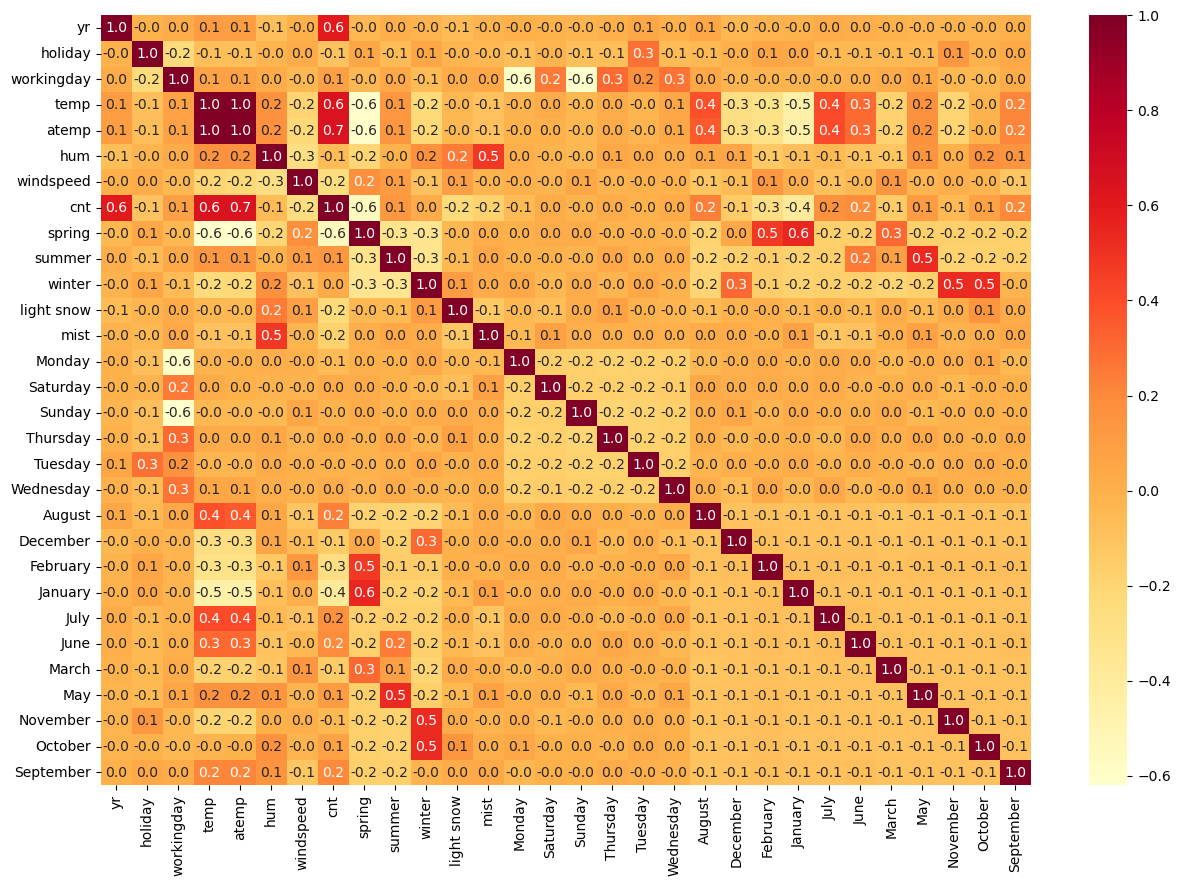

In [30]:

plt.figure(figsize=(15, 10))
sns.heatmap(round(train_bikeSrRelavantDf.corr(),2), annot=True, fmt=".1f", cmap="YlOrRd")
plt.show()

### Heatmap Observation
- Heatmap shows minimum 14 features have medium to strong relationship

## Working on Training Data, separating into x_train and y_train

In [31]:
y_train_bikeSrRelavantDf =train_bikeSrRelavantDf.pop('cnt')
x_train_bikeSrRelavantDf =train_bikeSrRelavantDf
x_train_bikeSrRelavantDf.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'light snow', 'mist', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September'],
      dtype='object')

In [32]:
linearRegression=LinearRegression()
linearRegression.fit(x_train_bikeSrRelavantDf,y_train_bikeSrRelavantDf)
rfe=RFE(linearRegression, n_features_to_select=14)
rfe=rfe.fit(x_train_bikeSrRelavantDf,y_train_bikeSrRelavantDf)

feature_ranking=list(zip(x_train_bikeSrRelavantDf.columns,rfe.support_,rfe.ranking_))

feature_ranking


[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 15),
 ('winter', True, 1),
 ('light snow', True, 1),
 ('mist', True, 1),
 ('Monday', False, 9),
 ('Saturday', False, 7),
 ('Sunday', False, 3),
 ('Thursday', False, 8),
 ('Tuesday', False, 16),
 ('Wednesday', False, 14),
 ('August', False, 10),
 ('December', False, 2),
 ('February', False, 5),
 ('January', True, 1),
 ('July', True, 1),
 ('June', False, 11),
 ('March', False, 13),
 ('May', False, 6),
 ('November', True, 1),
 ('October', False, 12),
 ('September', True, 1)]

In [33]:

rfeColLst=list(x_train_bikeSrRelavantDf.columns[rfe.support_])

print('RFE selected column: \n',x_train_bikeSrRelavantDf.columns[rfe.support_])
print('\n')
print('RFE not Selected column: \n',x_train_bikeSrRelavantDf.columns[~rfe.support_])


x_train_rfe_bkSrDf=x_train_bikeSrRelavantDf[rfeColLst]
x_train_rfe_bkSrDf.head()


RFE selected column: 
 Index(['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'spring',
       'winter', 'light snow', 'mist', 'January', 'July', 'November',
       'September'],
      dtype='object')


RFE not Selected column: 
 Index(['workingday', 'summer', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'August', 'December', 'February', 'June',
       'March', 'May', 'October'],
      dtype='object')


,yr,holiday,temp,atemp,hum,windspeed,spring,winter,light snow,mist,January,July,November,September
653,1,0,0.509887,0.501133,0.575354,0.300794,0,1,0,0,0,0,0,0
576,1,0,0.815169,0.766351,0.725633,0.264686,0,0,0,0,0,1,0,0
426,1,0,0.442393,0.438975,0.640189,0.255342,1,0,0,1,0,0,0,0
728,1,0,0.245101,0.200348,0.498067,0.663106,1,0,0,0,0,0,0,0
482,1,0,0.395666,0.391735,0.504508,0.188475,0,0,0,1,0,0,0,0


# Building model and analyzing summary using statsmodel

In [34]:
# Adding constant
x_train_rfe_bkSrDf_sm=sm.add_constant(x_train_rfe_bkSrDf)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
vifColLst=x_train_rfe_bkSrDf.columns
vifDf['features']=vifColLst
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf.values,i) for i in range(x_train_rfe_bkSrDf.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif',ascending=False)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     187.4
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.87e-187
Time:                        11:36:54   Log-Likelihood:                 507.81
No. Observations:                 510   AIC:                            -985.6
Df Residuals:                     495   BIC:                            -922.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3516      0.032     11.119      0.0

,features,vif
3,atemp,351.93
2,temp,351.52
4,hum,23.79
5,windspeed,4.17
6,spring,2.92
7,winter,2.62
9,mist,2.24
0,yr,2.07
10,January,1.67
12,November,1.59


## Observations
- It can be seen that P-Value for November(.074) is greater than .05
- atemp p-value(0.475) is also greater than .05

# Building model after removing feature "atemp"

In [35]:
# Adding constant
x_train_rfe_bkSrDf_new=x_train_rfe_bkSrDf.drop(['atemp'],axis=1)

x_train_rfe_bkSrDf_new_sm=sm.add_constant(x_train_rfe_bkSrDf_new)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_new_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
vifColLst=x_train_rfe_bkSrDf_new.columns
vifDf['features']=vifColLst
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf_new.values,i) for i in range(x_train_rfe_bkSrDf_new.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif',ascending=False)



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.9
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.67e-188
Time:                        11:36:54   Log-Likelihood:                 507.55
No. Observations:                 510   AIC:                            -987.1
Df Residuals:                     496   BIC:                            -927.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3532      0.032     11.203      0.0

,features,vif
3,hum,23.27
2,temp,15.99
4,windspeed,4.07
5,spring,2.91
6,winter,2.59
8,mist,2.24
0,yr,2.07
9,January,1.66
11,November,1.59
10,July,1.41


## Observation

- P value for November(0.072) is greater than .05.
- There is no change in adjusted R-sq it remain same .837


## Removing feature November

In [36]:
# Removing November
x_train_rfe_bkSrDf_new2=x_train_rfe_bkSrDf_new.drop(['November'],axis=1)

# Adding constant
x_train_rfe_bkSrDf_new2_sm=sm.add_constant(x_train_rfe_bkSrDf_new2)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_new2_sm).fit()
print(linearModel.summary())


# Calculating VIF
vifDf=pd.DataFrame()
vifColLst=x_train_rfe_bkSrDf_new2.columns
vifDf['features']=vifColLst
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf_new2.values,i) for i in range(x_train_rfe_bkSrDf_new2.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif',ascending=False)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.5
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          5.52e-189
Time:                        11:36:54   Log-Likelihood:                 505.89
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     497   BIC:                            -930.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3474      0.031     11.052      0.0

,features,vif
3,hum,23.25
2,temp,15.92
4,windspeed,4.03
5,spring,2.90
8,mist,2.23
6,winter,2.11
0,yr,2.07
9,January,1.66
10,July,1.41
7,light snow,1.21


## Observations
- Removing Temp reduces Adj. R-squared from 0.837 to .836. This is not a significant drop
- P-Value for all the features are below .05
- VIF value for hum and temp are 23.25 and 15.92 respectively. VIF needs to be below 5
- We will first remove hum as it is larger of two and then observe change in modle and vif

## Verifying VIF
### Rebuilding Model after removing "humidity"

In [37]:
# Removing Humidity
x_train_rfe_bkSrDf_new3=x_train_rfe_bkSrDf_new2.drop(['hum'],axis=1)

# Adding constant
x_train_rfe_bkSrDf_new3_sm=sm.add_constant(x_train_rfe_bkSrDf_new3)

# Fitting Model
linearModel=sm.OLS(y_train_bikeSrRelavantDf,x_train_rfe_bkSrDf_new3_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
vifColLst=x_train_rfe_bkSrDf_new3.columns
vifDf['features']=vifColLst
vifDf['vif']=[variance_inflation_factor(x_train_rfe_bkSrDf_new3.values,i) for i in range(x_train_rfe_bkSrDf_new3.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif',ascending=False)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.7
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.13e-186
Time:                        11:36:54   Log-Likelihood:                 497.58
No. Observations:                 510   AIC:                            -971.2
Df Residuals:                     498   BIC:                            -920.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2657      0.025     10.843      0.0

,features,vif
2,temp,4.63
3,windspeed,4.00
4,spring,2.25
0,yr,2.06
8,January,1.60
7,mist,1.53
5,winter,1.40
9,July,1.36
10,September,1.20
6,light snow,1.08


### Observations
- VIF for temp is(4.63) i.e below 5
- P-Value for all features is below .05 and VIF for all features below 5

## Error Terms Analysis and homosedasticity

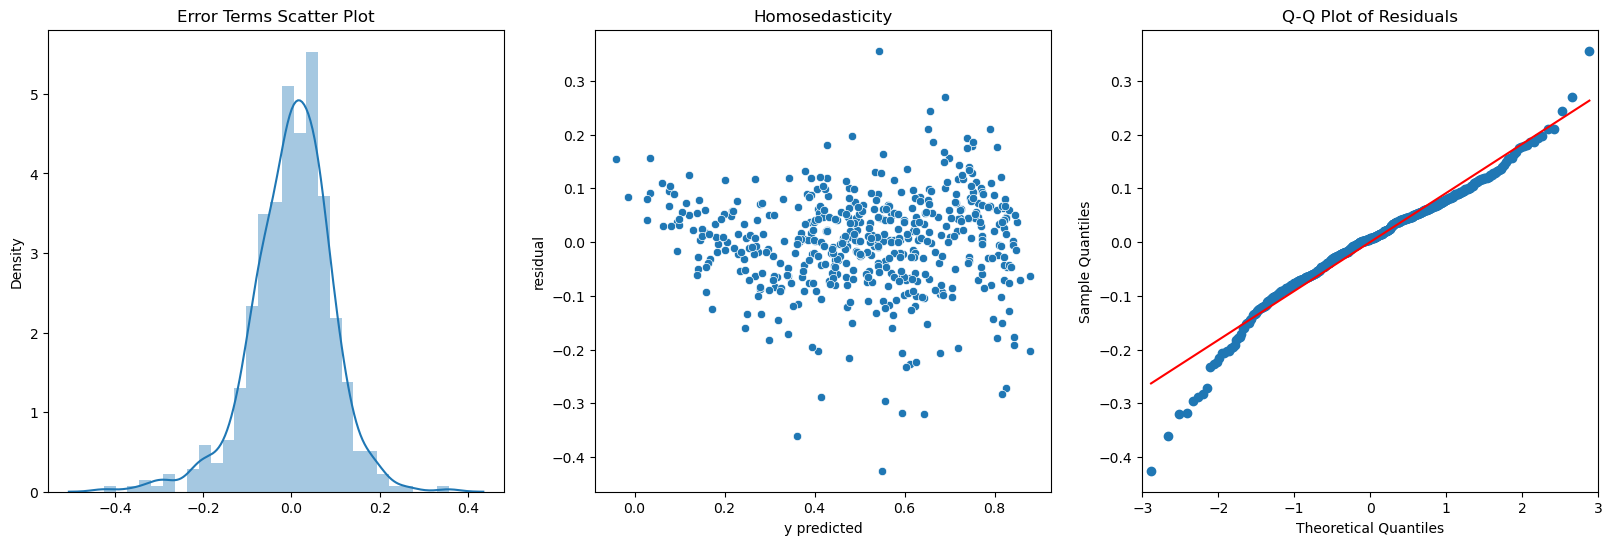

In [38]:
x_train_rfe_bkSrDf_new3_sm.columns

y_train_pred=linearModel.predict(x_train_rfe_bkSrDf_new3_sm)
residual=y_train_bikeSrRelavantDf-y_train_pred

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_train_pred,y=residual , ax=axis[1])
axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")
import scipy.stats as stats

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()


### Error Terms have normal distribution and centered around zero

## Analysing Test Data

In [39]:
test_bikeSrRelavantDf[ScaleColumnLst]=scaler.transform(test_bikeSrRelavantDf[ScaleColumnLst])


testnew3Cols=x_train_rfe_bkSrDf_new3.columns
y_test_bikeSrRelavantDf=test_bikeSrRelavantDf.pop('cnt')
x_test_bikeSrRelavantDf_sm=sm.add_constant(test_bikeSrRelavantDf[testnew3Cols])

x_test_bikeSrRelavantDf_sm.head()

,const,yr,holiday,temp,windspeed,spring,winter,light snow,mist,January,July,September
184,1.0,0,1,0.831783,0.084219,0,0,0,1,0,1,0
535,1.0,1,0,0.901354,0.153728,0,0,0,0,0,0,0
299,1.0,0,0,0.511964,0.334206,0,1,0,1,0,0,0
221,1.0,0,0,0.881625,0.339570,0,0,0,0,0,0,0
152,1.0,0,0,0.817246,0.537414,0,0,0,0,0,0,0


In [40]:
y_testPred=linearModel.predict(x_test_bikeSrRelavantDf_sm)

print(' Training r2 score',r2_score(y_true=y_train_bikeSrRelavantDf, y_pred=y_train_pred))
print(' Test r2 score',r2_score(y_true=y_test_bikeSrRelavantDf, y_pred=y_testPred))

 Training r2 score 0.8347491501104349
 Test r2 score 0.8036570309481511


### There is not much difference test and training r2 score
- Training R2_score .834
- Test R2_score .803

In [66]:
result = pd.concat([y_testPred,x_test_bikeSrRelavantDf_sm], axis=1)
result=pd.DataFrame(result)
pd.rename()
# sns.pairplot(data=result, y_vars='cnt',x_vars=['holiday', 'temp', 'yr', 'result','winter','light snow'])
# sns.pairplot(data=result, y_vars='cnt',x_vars=['mist','September','January', 'July'])
# plt.show()


,0,const,yr,holiday,temp,windspeed,spring,winter,light snow,mist,January,July,September
184,0.366601,1.0,0,1,0.831783,0.084219,0,0,0,1,0,1,0
535,0.868469,1.0,1,0,0.901354,0.153728,0,0,0,0,0,0,0
299,0.401139,1.0,0,0,0.511964,0.334206,0,1,0,1,0,0,0
221,0.597520,1.0,0,0,0.881625,0.339570,0,0,0,0,0,0,0
152,0.540284,1.0,0,0,0.817246,0.537414,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,0.388081,1.0,1,0,0.257562,0.287411,1,0,0,1,0,0,0
702,0.726842,1.0,1,0,0.519232,0.283397,0,1,0,0,0,0,0
127,0.508827,1.0,0,0,0.584649,0.069510,0,0,0,0,0,0,0
640,0.779076,1.0,1,0,0.745598,0.052115,0,1,0,1,0,0,0


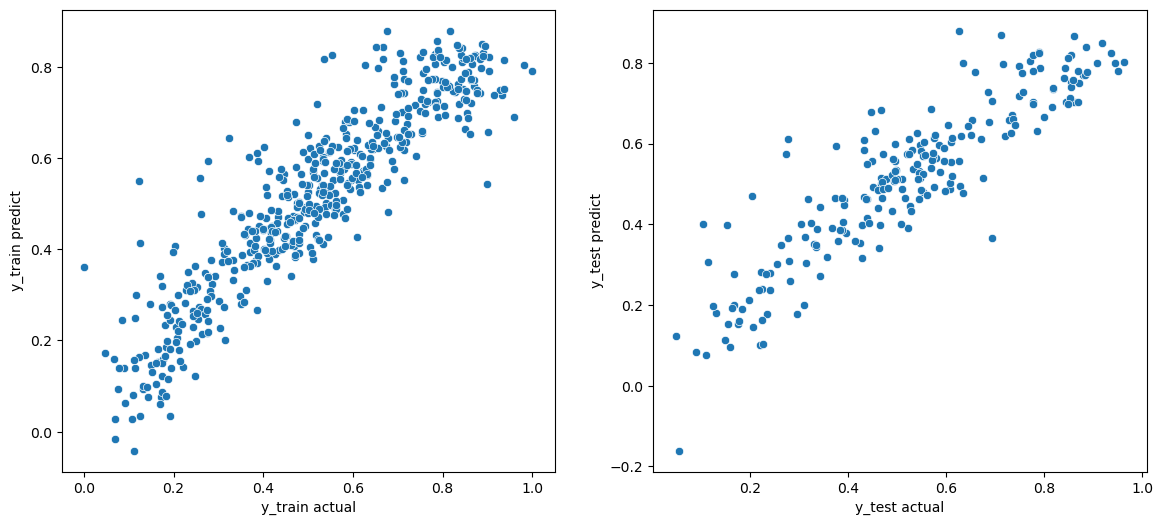

In [41]:
# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 2, figsize=(14, 6))


sns.scatterplot(x=y_train_bikeSrRelavantDf,y=y_train_pred, ax=axis[0])
axis[0].set_xlabel('y_train actual') 
axis[0].set_ylabel('y_train predict') 


sns.scatterplot(x=y_test_bikeSrRelavantDf,y=y_testPred , ax=axis[1])
axis[1].set_xlabel('y_test actual') 
axis[1].set_ylabel('y_test predict') 



plt.show()
